In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [4]:
class LinearRegression:
    def __init__(self, X, y, learning_rate, tolerance, max_iterations, lambda_, sgd_iterations, min_batch_size, max_batch_size, gd=False, regularization=False, sgd=False):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.max_iterations = max_iterations
        self.lambda_ = lambda_  # regularization parameter
        self.sgd_iterations = sgd_iterations
        #self.batch_size = batch_size
        self.gd = gd
        self.regularization = regularization
        self.sgd = sgd
        self.min_batch_size = min_batch_size
        self.max_batch_size = max_batch_size
        

    # Step_1: Split data into training and testing
    def split_data(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, shuffle=True)
        return X_train, X_test, y_train, y_test

    # Step_2: Adding one new column at beginning for intercept
    def add_bias(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])

    # Step_3: Normalizing the training data and then adding column at beginning for intercept
    def normalize_train(self, X):
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_norm = (X - mean) / std
        X_norm = self.add_bias(X_norm)
        return mean, std, X_norm

    def normalize_test(self, X, mean, std):
        X_norm = (X - mean) / std
        X_norm = self.add_bias(X_norm)
        return X_norm

    # Step_4: Closed Form solution/Normal Equation (Analytical Approach)
    
    def rank(self, X):
        rank = np.linalg.matrix_rank(X)
        return rank

    def checkFullrank(self, X):
        rank = self.rank(X)
        if rank == min(X.shape):
            print("It's full rank")
            self.Fullrank = True
        else:
            self.Fullrank = False

    def checkLowRank(self, X):
        if X.shape[1] > X.shape[0]:
            print("It's low rank")
            self.LowRank = True
        else:
            self.LowRank = False
            
    def normal_equation(self, X, y):
        self.w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        
    # Regularization (Ridge) with closed form solution
    def ridge_regression_normal(self, X, y, lambda_):
        m = X.shape[1]  # Number of features including intercept
        I = np.identity(m)  # Identity matrix
        #I[0, 0] = 0  # Do not regularize the bias term
        self.w = np.linalg.inv(X.T.dot(X) + lambda_ * I).dot(X.T).dot(y)
        

    def predict(self, X):
        return X.dot(self.w)

    # Sum of Squared Errors
    def sse(self, X, y):
        y_hat = self.predict(X)
        return ((y_hat - y) ** 2).sum()

    # Root Mean Squared Error
    def rmse(self, X, y):
        sse = self.sse(X, y)
        return np.sqrt(sse / X.shape[0])

    # Cost function (RMSE)
    def cost_function_rmse(self, X, y):
        rmse = self.rmse(X, y)
        return rmse / 2

    # Gradient of cost function
    def cost_derivative(self, X, y):
        y_hat = self.predict(X)
        return (y_hat - y).dot(X)

    def reg_cost_derivative(self, X, y):
        y_hat = self.predict(X)
        return (y_hat - y).dot(X) / X.shape[0]

    # Gradient Descent
    def gradient_descent(self, X, y):
        self.errors = []  # list to keep track of errors
        prev_error = float(np.inf)  # variable that keeps track of previous error

        # Initialize weights with size including intercept term
        self.w = np.zeros(X.shape[1])

        for i in tqdm(range(self.max_iterations)):
            grad = self.cost_derivative(X, y)
            self.w = self.w - self.learning_rate * grad
            current_error = self.cost_function_rmse(X, y)
            self.errors.append(current_error)
            if abs(current_error - prev_error) < self.tolerance:
                print("The model stopped learning")
                break
            prev_error = current_error

        self.plot_rmse(self.errors)

    # Regularization using norm 2 (Ridge Regression)
    def reg_gradient_descent(self, X, y,lambda_):
        self.errors = []  # list to keep track of errors
        prev_error = float(np.inf)  # variable that keeps track of previous error

        # Initialize weights with size including intercept term
        self.w = np.zeros(X.shape[1])

        for i in tqdm(range(self.max_iterations)):
            grad = self.cost_derivative(X, y) + (lambda_) * self.w
            self.w = self.w - self.learning_rate * grad
            current_error = self.cost_function_rmse(X, y)
            self.errors.append(current_error)
            if abs(current_error - prev_error) < self.tolerance:
                print("The model stopped learning")
                break
            prev_error = current_error

        self.plot_rmse(self.errors)

    def sgradient_descent(self, X, y):
        self.errors = []  # list to keep track of errors
        self.batch_sizes = []  # list to keep track of batch sizes
        prev_error = float(np.inf)  # variable that keeps track of previous error

        # Initialize weights with size including intercept term
        self.w = np.zeros(X.shape[1])

        for i in tqdm(range(self.sgd_iterations)):
            current_batch_size = np.random.randint(self.min_batch_size, self.max_batch_size)
            self.batch_sizes.append(current_batch_size)
            batch_indices = np.random.randint(0, X.shape[0], current_batch_size)
            self.w = self.w - self.learning_rate * self.cost_derivative(X[batch_indices], y[batch_indices])
            current_error = self.cost_function_rmse(X, y)
            self.errors.append(current_error)
            if abs(current_error - prev_error) < self.tolerance:
                print("The model stopped learning")
                break
            prev_error = current_error

        self.plot_rmse(self.errors)
        print("Batch sizes used during training:", self.batch_sizes)                            
                                
        
    # Plot RMSE
    def plot_rmse(self, error_sequence):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        # Data for plotting
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s, label='RMSE')  

        ax.set(xlabel='iterations', ylabel='RMSE', title='Error Trend')
        ax.grid()
        ax.legend()

        plt.show()

    # Step_5: One main function connecting everything together
    
    def fit(self):
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = self.split_data()
        # Normalize the training data
        mean, std, X_train = self.normalize_train(X_train)
        # Normalize the testing data using the training data mean and std
        X_test = self.normalize_test(X_test, mean, std)

        # Check if Gradient Descent or Stochastic Gradient Descent is not specified
        if not self.gd and not self.sgd:
            print("Solving using Normal Equation...")

            # Check if regularization is required
            if self.regularization and self.lambda_ > 0:
                print("With Regularization")
                self.ridge_regression_normal(X_train, y_train, self.lambda_)
            else:
                # Check if the matrix is of full rank
                self.checkFullrank(X_train)
                if self.Fullrank:
                    print("Matrix is full rank, solving with Normal Equation without regularization")
                    self.normal_equation(X_train, y_train)
                else:
                    print("Matrix is not full rank, solving with Gradient Descent without regularization")
                    self.gradient_descent(X_train, y_train)
        elif self.gd:
            print("Solving using Gradient Descent...")

            # Check if regularization is required
            if self.regularization and self.lambda_ > 0:
                print("With Regularization")
                self.reg_gradient_descent(X_train, y_train, self.lambda_)
            else:
                print("Without Regularization")
                self.gradient_descent(X_train, y_train)
        elif self.sgd:
            print("Solving using Stochastic Gradient Descent...")
            self.sgradient_descent(X_train, y_train)

        print("Final weights:", self.w)
        
        print("Train_RMSE: ", self.rmse(X_train, y_train))
        print("Train_SSE: ", self.sse(X_train, y_train))
        print("Test_RMSE: ", self.rmse(X_test, y_test))
        print("Test_SSE: ", self.sse(X_test, y_test))

## Housing Dataset

In [5]:
df_housing = pd.read_csv(r"../dataset/housing.csv")

In [6]:
df_housing.head()

,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [7]:
X_housing = df_housing.iloc[:, :-1].values
y_housing = df_housing.iloc[:, -1].values

In [8]:
clf = LinearRegression(X_housing, y_housing, learning_rate=0.0004, tolerance=0.005, max_iterations=50000, lambda_ = 0,
                       sgd_iterations=100,min_batch_size=0, max_batch_size=0, gd=False, regularization=False, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Normal Equation...
It's full rank
Matrix is full rank, solving with Normal Equation without regularization
Final weights: [22.83597734 -0.99619476  1.14683237  0.0909117   0.74295545 -2.22916075
  2.91550516 -0.1044792  -3.380708    2.45739825 -1.83611073 -2.19462061
  0.65669255 -3.78740528]
Train_RMSE:  4.726860227883014
Train_SSE:  7887.152287721617
Test_RMSE:  4.597958467766612
Test_SSE:  3213.465754838618


In [9]:
clf = LinearRegression(X_housing, y_housing, learning_rate=0.0004, tolerance=0.005, max_iterations=50000, lambda_=0.001,
                       sgd_iterations=100, min_batch_size=0, max_batch_size=0, gd=False, regularization=True, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Normal Equation...
With Regularization
Final weights: [22.68293858 -0.77708765  1.18453662  0.14115796  0.6579575  -1.9334628
  2.85579764  0.21512742 -2.7702171   2.75714166 -2.28437931 -2.02700642
  0.6237938  -3.54435236]
Train_RMSE:  4.46298754242952
Train_SSE:  7031.1450047700255
Test_RMSE:  5.185875054565435
Test_SSE:  4087.7816123977354


Solving using Gradient Descent...
Without Regularization


  0%|          | 27/50000 [00:00<00:03, 15349.17it/s]

The model stopped learning


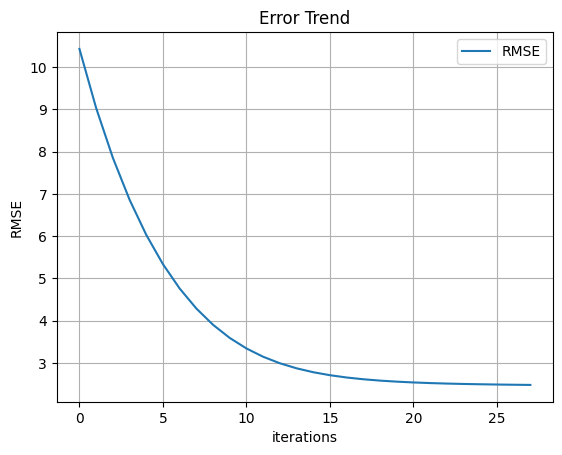

Final weights: [22.58622736 -0.85021034  0.2327993  -0.39898446  0.78815348 -0.99630204
  3.12749523 -0.13444913 -1.89759129  0.86766453 -0.39853331 -1.88037126
  0.57083089 -3.67054595]
Train_RMSE:  4.9647954993052625
Train_SSE:  8701.165605522392
Test_RMSE:  4.358843402567251
Test_SSE:  2887.9264028318157


In [10]:
clf = LinearRegression(X_housing, y_housing, learning_rate=0.0004, tolerance=0.005, max_iterations=50000, lambda_=0,
                       sgd_iterations=100, min_batch_size=0, max_batch_size=0, gd=True, regularization=False, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Gradient Descent...
With Regularization


  0%|          | 26/50000 [00:00<00:02, 17249.59it/s]

The model stopped learning


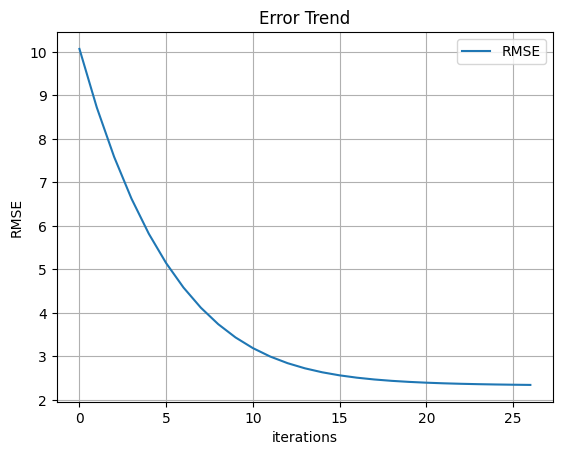

Final weights: [21.88832291 -0.84770724  0.35835266 -0.66034517  0.47527344 -0.83976548
  3.0324265  -0.19254772 -1.78871789  0.8564258  -0.36016854 -1.76666036
  0.93568733 -2.99992736]
Train_RMSE:  4.69051975190777
Train_SSE:  7766.344366692037
Test_RMSE:  5.2176469638418945
Test_SSE:  4138.023655571858


In [11]:
clf = LinearRegression(X_housing, y_housing, learning_rate=0.0004, tolerance=0.005, max_iterations=50000, lambda_=0.001,
                       sgd_iterations=100, min_batch_size=0, max_batch_size=0, gd=True, regularization=True, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Stochastic Gradient Descent...


 77%|███████▋  | 77/100 [00:00<00:00, 6756.51it/s]

The model stopped learning


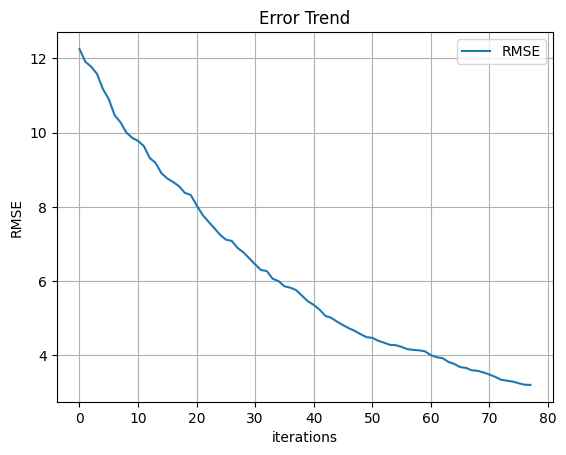

Batch sizes used during training: [45, 69, 20, 37, 84, 58, 89, 51, 71, 38, 22, 36, 86, 38, 79, 38, 31, 35, 63, 22, 87, 79, 61, 69, 70, 43, 17, 80, 50, 66, 67, 72, 23, 93, 33, 76, 24, 29, 82, 85, 66, 74, 98, 38, 63, 58, 69, 45, 67, 51, 10, 53, 38, 44, 10, 34, 68, 31, 12, 24, 76, 59, 35, 96, 66, 90, 21, 74, 15, 44, 64, 57, 93, 61, 39, 69, 63, 11]
Final weights: [19.07178637 -0.31933315  0.55039123 -0.37503603  0.61117177 -0.59113088
  3.27152597 -0.08794528 -1.30401887  0.15849565 -0.47429635 -1.57906434
  0.9035166  -2.89845093]
Train_RMSE:  6.410642895672162
Train_SSE:  14507.008844548682
Test_RMSE:  6.058246841536332
Test_SSE:  5578.757928533711


In [12]:
clf = LinearRegression(X_housing, y_housing, learning_rate=0.0004, tolerance=0.005, max_iterations=50000, lambda_=0,
                       sgd_iterations=100, min_batch_size=10, max_batch_size=100, gd=False, regularization=False, sgd=True)
clf.fit()


**Smaller batch sizes in stochastic gradient descent (SGD) lead to faster convergence and lower RMSE values as they update the model more frequently with diverse data points, enabling quicker adjustments towards the optimal solution. Random shuffling ensures effectiveness by preventing the model from being trapped in local minima.**

## Yacht DataSet

In [13]:
df_yacht = pd.read_csv(r"../dataset/yachtData.csv")


In [14]:
df_yacht.head()

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82


In [15]:
X_yacht = df_yacht.iloc[:, :-1].values
y_yacht = df_yacht.iloc[:, -1].values

In [16]:
clf = LinearRegression(X_yacht, y_yacht, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_ = 0,
                       sgd_iterations=100, min_batch_size=0, max_batch_size=0, gd=False, regularization=False, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Normal Equation...
It's full rank
Matrix is full rank, solving with Normal Equation without regularization
Final weights: [10.33504673 -0.09316082 -0.92563172 -0.73240761  0.6667469   0.29125555
 11.89800375]
Train_RMSE:  8.583561906142121
Train_SSE:  15766.992489266871
Test_RMSE:  9.55083267591247
Test_SSE:  8483.311646704795


In [17]:
clf = LinearRegression(X_yacht, y_yacht, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0.001,
                       sgd_iterations=100, min_batch_size=0, max_batch_size=0, gd=False, regularization=True, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Normal Equation...
With Regularization
Final weights: [ 9.80906631  0.49261278  0.17733535 -0.91394627  0.03565528  1.1850387
 11.96202065]
Train_RMSE:  8.71826009356209
Train_SSE:  16265.724638625416
Test_RMSE:  9.391439867249835
Test_SSE:  8202.52027855577


Solving using Gradient Descent...
Without Regularization


  0%|          | 17/50000 [00:00<?, ?it/s]

The model stopped learning


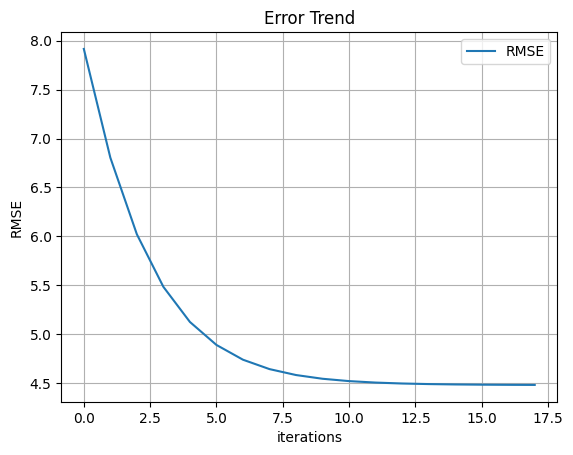

Final weights: [10.58725345  0.59347099 -0.45122174 -0.07455274  0.16277681 -0.21487921
 12.48447948]
Train_RMSE:  8.963459658044556
Train_SSE:  17193.53233485794
Test_RMSE:  8.674625803341296
Test_SSE:  6998.1693530035


In [18]:
clf = LinearRegression(X_yacht, y_yacht, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0,
                       sgd_iterations=100, min_batch_size=0, max_batch_size=0, gd=True, regularization=False, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Gradient Descent...
With Regularization


  0%|          | 17/50000 [00:00<00:07, 6854.10it/s]

The model stopped learning


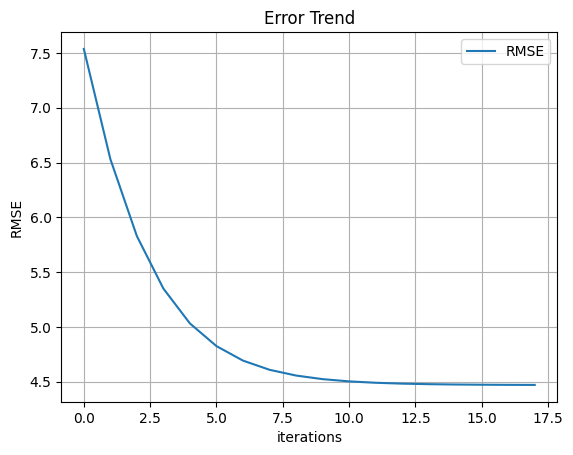

Final weights: [ 9.41341285  0.54642415 -1.23215841  0.05104763 -0.17380326 -0.15979105
 11.89984719]
Train_RMSE:  8.941775979060647
Train_SSE:  17110.446539177086
Test_RMSE:  8.818665775383517
Test_SSE:  7232.504543386611


In [19]:
clf = LinearRegression(X_yacht, y_yacht, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0.001,
                       sgd_iterations=100, min_batch_size=0, max_batch_size=0, gd=True, regularization=True, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Stochastic Gradient Descent...


 43%|████▎     | 43/100 [00:00<00:00, 11154.37it/s]

The model stopped learning


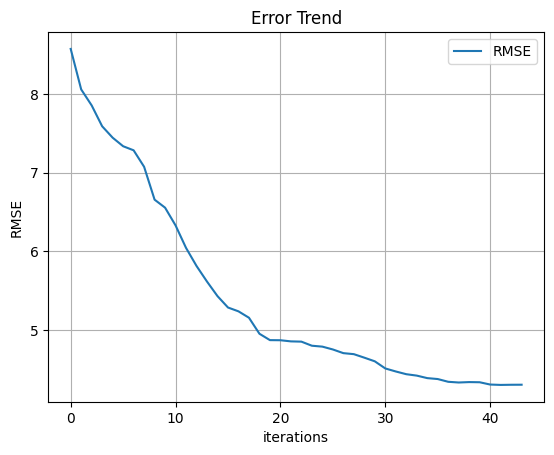

Batch sizes used during training: [36, 96, 49, 44, 24, 27, 15, 42, 76, 62, 33, 90, 98, 45, 46, 66, 36, 63, 91, 51, 29, 35, 33, 52, 28, 30, 57, 53, 96, 63, 58, 55, 86, 53, 67, 34, 78, 45, 35, 21, 73, 11, 22, 31]
Final weights: [ 9.68606079  0.28246025 -0.77572431 -0.03493473 -0.62750723  0.31989207
 11.23166045]
Train_RMSE:  8.618740288076216
Train_SSE:  15896.494408807934
Test_RMSE:  9.859189205628144
Test_SSE:  9039.93589669083


In [20]:
clf = LinearRegression(X_yacht, y_yacht, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0,
                       sgd_iterations=100, min_batch_size=10, max_batch_size=100, gd=False, regularization=False, sgd=True)
clf.fit()


## Concrete Dataset

In [21]:
df_concrete = pd.read_csv(r"../dataset/concreteData.csv")


In [22]:
df_concrete.head()

,540,0,0.1,162,2.5,1040,676,28,79.99
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
1,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03


In [23]:

X_concrete = df_concrete.iloc[:, :-1].values
y_concrete = df_concrete.iloc[:, -1].values

In [24]:
clf = LinearRegression(X_concrete, y_concrete, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_ = 0,
                       sgd_iterations=100, min_batch_size=0, max_batch_size=0, gd=False, regularization=False, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Normal Equation...
It's full rank
Matrix is full rank, solving with Normal Equation without regularization
Final weights: [35.51322222 12.50561378  8.9585404   5.87892577 -2.86628605  1.71188739
  1.83243043  2.35490653  7.24056908]
Train_RMSE:  10.19772370091085
Train_SSE:  74875.36944968559
Test_RMSE:  10.67601849299466
Test_SSE:  35219.00759659406


In [25]:
clf = LinearRegression(X_concrete, y_concrete, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0.001,
                       sgd_iterations=100, min_batch_size=0, max_batch_size=0, gd=False, regularization=True, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Normal Equation...
With Regularization
Final weights: [35.78271419 11.93857032  8.35750249  4.82205584 -3.67658371  1.87849403
  1.14964106  0.89722533  6.85866975]
Train_RMSE:  10.469177938918763
Train_SSE:  78914.65443605519
Test_RMSE:  10.012182879673702
Test_SSE:  30975.33605895364


Solving using Gradient Descent...
Without Regularization


  0%|          | 30/50000 [00:00<00:03, 14787.77it/s]

The model stopped learning


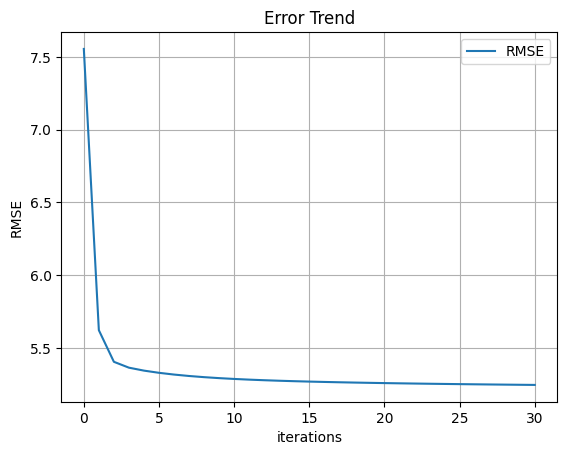

Final weights: [35.96679167  9.9220655   5.82413217  3.01962149 -5.34248524  1.91727099
 -0.74269455 -1.21044685  7.12548544]
Train_RMSE:  10.493611781190495
Train_SSE:  79283.43951432477
Test_RMSE:  10.17455888539345
Test_SSE:  31988.1893903127


In [26]:
clf = LinearRegression(X_concrete, y_concrete, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0,
                       sgd_iterations=100, min_batch_size=0, max_batch_size=0, gd=True, regularization=False, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Gradient Descent...
With Regularization


  0%|          | 33/50000 [00:00<00:01, 27473.61it/s]

The model stopped learning


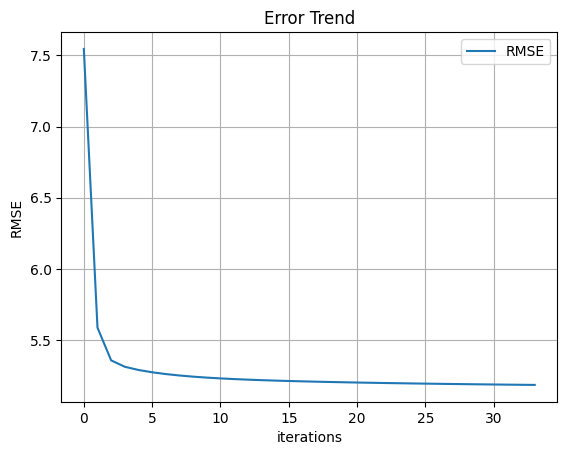

Final weights: [35.71103373  9.93769504  6.3559823   3.35152667 -5.32213811  1.83259221
 -0.9167584  -1.21011081  7.45025956]
Train_RMSE:  10.371028801799019
Train_SSE:  77441.93165357626
Test_RMSE:  10.51362929094577
Test_SSE:  34155.74786803675


In [27]:
clf = LinearRegression(X_concrete, y_concrete, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0.001,
                       sgd_iterations=100, min_batch_size=0, max_batch_size=0, gd=True, regularization=True, sgd=False)
clf.fit()

# Since normal equation doesn't populate the errors list, we only plot RMSE if using gradient descent or SGD
#if clf.gd or clf.sgd:
 #   clf.plot_rmse(clf.errors)

Solving using Stochastic Gradient Descent...


 71%|███████   | 71/100 [00:00<00:00, 13541.09it/s]

The model stopped learning


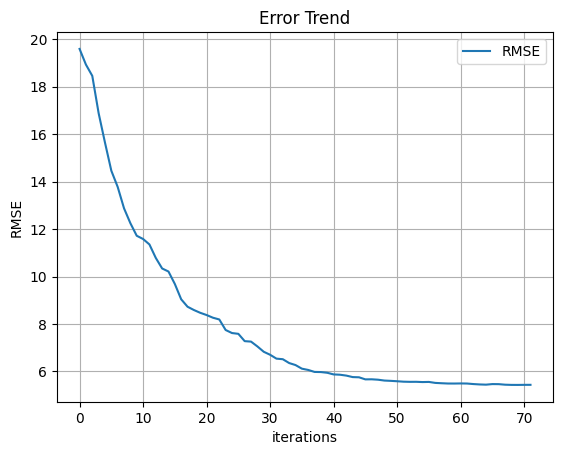

Batch sizes used during training: [23, 41, 27, 91, 82, 87, 60, 66, 62, 62, 13, 25, 57, 63, 20, 82, 92, 58, 22, 34, 26, 21, 22, 98, 54, 15, 75, 16, 62, 97, 38, 70, 18, 69, 83, 91, 82, 47, 20, 21, 80, 18, 72, 83, 49, 92, 28, 52, 67, 13, 97, 24, 25, 23, 93, 33, 60, 46, 22, 11, 15, 23, 84, 55, 96, 97, 27, 58, 66, 34, 20, 18]
Final weights: [35.5849474   6.72630971  3.2577927   0.5187082  -5.17665606  3.66687482
 -1.7203481  -2.98906902  6.55446578]
Train_RMSE:  10.870694777123964
Train_SSE:  85083.84355492095
Test_RMSE:  10.072009084987595
Test_SSE:  31346.61840549445


In [28]:
clf = LinearRegression(X_concrete, y_concrete, learning_rate=0.1 * 10**-2, tolerance=0.1 * 10**-2, max_iterations=50000, lambda_=0,
                       sgd_iterations=100, min_batch_size=10, max_batch_size=100, gd=False, regularization=False, sgd=True)
clf.fit()


## Observations:

## Effects on Learning:

### Learning Rate:
- **Effect on Convergence Speed:** A higher learning rate accelerates convergence, making the model reach an acceptable solution faster. However, if the learning rate is too high, the model might oscillate around the optimal solution or even diverge.

### Regularization Parameter:
- **Control Overfitting:** Increasing the regularization parameter encourages the model to favor simpler solutions, which helps prevent overfitting on the training data. However, setting it too high may excessively constrain the model, leading to underfitting and poor performance on both training and test data.
- **Balance Between Bias and Variance:** Finding the right balance in the regularization parameter is crucial. A moderate regularization parameter value typically achieves the best tradeoff between bias and variance, resulting in a model that generalizes well to unseen data.

## Conclusion:
Optimizing the learning rate and regularization parameters involves finding the right balance between convergence speed, stability, and model complexity. Experimentation and validation on a separate validation dataset are essential to determine the optimal values for these parameters, ensuring that the trained model generalizes well to unseen data while avoiding underfitting and overfitting issues.

